In [2]:
#Environment variables
%env JULIA_NUM_THREADS=auto
%env OCTOFITTERPY_AUTOLOAD_EXTENSIONS=yes

env: JULIA_NUM_THREADS=auto
env: OCTOFITTERPY_AUTOLOAD_EXTENSIONS=yes


In [3]:
#Imports 
import numpy as np
import astropy.units as u
import matplotlib.pylab as plt
import matplotlib.colors as colors
from PyAstronomy import pyasl
import astropy.constants as const
import pandas as pd
import matplotlib.lines as mlines
from astropy.table import Table
from datetime import datetime
from scipy import stats
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar

import sys
sys.path
sys.path.append(r"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\two_body\orbit_utilities")
print(sys.path)
import two_body_utils as utils

import octofitterpy as octo

['C:\\Users\\macke\\anaconda3\\envs\\octo\\python311.zip', 'C:\\Users\\macke\\anaconda3\\envs\\octo\\Lib', 'C:\\Users\\macke\\anaconda3\\envs\\octo\\DLLs', 'C:\\Users\\macke\\anaconda3\\envs\\octo', '', 'C:\\Users\\macke\\anaconda3\\envs\\octo\\Lib\\site-packages', 'C:\\Users\\macke\\anaconda3\\envs\\octo\\Lib\\site-packages\\win32', 'C:\\Users\\macke\\anaconda3\\envs\\octo\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\macke\\anaconda3\\envs\\octo\\Lib\\site-packages\\Pythonwin', 'C:\\Users\\macke\\OneDrive - Saint Marys University\\Summer Research 2025\\two_body\\orbit_utilities']
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Detected Jupyter notebook. Loading juliacall extension. Set `OCTOFITTERPY_AUTOLOAD_EXTENSIONS=no` to disable.


In [4]:
"""
Functions
"""

def fake_pos(pos, pm, acc, dt):
    """
    Gives a fake observed position using an observed angular position, velocity, and acceleration

    Parameters:
    - pos : Initial position (in mas)
    - pm : Proper motion (in mas/yr)
    - acc : Acceleration (in mas/yr²)
    - dt : Time offset(s) from the reference epoch in years

    Returns:
    - pos_final : calculated position (in mas)
    """
    return pos + pm * dt + 0.5 * acc * dt**2

def propagate_error(sigma_pm, sigma_acc, dt):
    """
    Propagates uncertainty in position due to uncertainties in
    proper motion and acceleration over time. No uncertainty in initial position is available.

    Parameters:
    - sigma_pm Uncertainty in proper motion (mas/yr)
    - sigma_acc : Uncertainty in acceleration (mas/yr²)
    - dt : Time from reference epoch (in years)

    Returns:
    - sigma_pos : Uncertainty in predicted position at time dt (in mas)
    """
    term_mu = (dt * sigma_pm) ** 2
    term_acc = (0.5 * dt**2 * sigma_acc) ** 2
    return np.sqrt(term_mu + term_acc)

In [18]:
"""
Mock dataset from single epoch observations for star A
"""

# Time offset between epochs in years
dt = 10              
# Decimal-year epochs
epochs_years = np.array([2010 - dt, 2010, 2010 + dt])   
# Convert to MJD
epochs_mjd = [octo.years2mjd(float(y)) for y in epochs_years]

# Observational Data 
# Star A
ra_A = (201.6967263*u.deg).to(u.mas).value
dec_A = (-47.4795835*u.deg).to(u.mas).value
pm_ra_A = 3.563 # mas year^-1
pm_dec_A = 2.564 # mas year^-1
acc_ra_A = -0.0069 # mas year^-2
acc_dec_A = 0.0085 # mas year^-2
# Omega Centauri Center 
# We find the center to be at (α,δ) = (13:26:47.24, −47:28:46.45).
# from https://iopscience.iop.org/article/10.1088/0004-637X/710/2/1032
# reference 6 in Haberle et al. (2024; Nature, Vol. 631) 
# We assume the IMBH is located at the cluster center
ra_cm_deg = 201.696834*u.deg
dec_cm_deg = -47.479569*u.deg
# Omega Centauri centre in mas
ra_cm_mas  = ra_cm_deg.to(u.mas).value
dec_cm_mas = dec_cm_deg.to(u.mas).value

# Uncertainties 
sigma_pm_ra_A = 0.038 # mas year^-1
sigma_pm_dec_A = 0.055 # mas year^-1
sigma_acc_ra_A = 0.0083 # mas year^-2
sigma_acc_dec_A = 0.0098 # mas year^-2


# Mock future and past observations
future_ra_A  = fake_pos(ra_A,  pm_ra_A,  acc_ra_A,  dt)
future_dec_A = fake_pos(dec_A, pm_dec_A, acc_dec_A, dt)
past_ra_A    = fake_pos(ra_A,  pm_ra_A,  acc_ra_A, -dt)
past_dec_A   = fake_pos(dec_A, pm_dec_A, acc_dec_A, -dt)

future_ra_A_err  = propagate_error(sigma_pm_ra_A,  sigma_acc_ra_A,  dt)
future_dec_A_err = propagate_error(sigma_pm_dec_A, sigma_acc_dec_A, dt)
past_ra_A_err    = propagate_error(sigma_pm_ra_A,  sigma_acc_ra_A, -dt)
past_dec_A_err   = propagate_error(sigma_pm_dec_A, sigma_acc_dec_A, -dt)

# Arrays of absolute positions 
ra_vals_A  = np.array([past_ra_A,  ra_A,  future_ra_A])   # mas
dec_vals_A = np.array([past_dec_A, dec_A, future_dec_A])  # mas

# Convert to positions relative to the assumed center of mass
ra_rel_A  = ra_vals_A  - ra_cm_mas      # delta RA = companion − host  [mas]
dec_rel_A = dec_vals_A - dec_cm_mas     # delta Dec = companion − host [mas]

# Uncertainty is required for Octofitter for all positions (small uncertainty instead of zero)
ra_errs_A = [past_ra_A_err, 1e-6, future_ra_A_err]
dec_errs_A = [past_dec_A_err, 1e-6, future_dec_A_err]


In [26]:
print()
print("Mock future RA of star A:", (future_ra_A*u.mas).to(u.deg), "±",(future_ra_A_err*u.mas).to(u.deg))
print("Mock future DEC of star A:", (future_dec_A*u.mas).to(u.deg), "±",(future_dec_A_err*u.mas).to(u.deg))
print()
print("Mock past RA of star A:", (past_ra_A*u.mas).to(u.deg), "±",(past_ra_A_err*u.mas).to(u.deg))
print("Mock past DEC of star A:", (past_dec_A*u.mas).to(u.deg), "±",(past_dec_A_err*u.mas).to(u.deg))
print()


Mock future RA of star A: 201.69672728876384 deg ± 1.0618316707056636e-08 deg
Mock future DEC of star A: -47.47958278659722 deg ± 1.5338289255453187e-08 deg

Mock past RA of star A: 201.69672530931942 deg ± 1.0618316707056636e-08 deg
Mock past DEC of star A: -47.47958421104167 deg ± 1.5338289255453187e-08 deg



In [50]:
"""
Orbital Calculations and Plots with Octofitter
"""
# We start by defining a likelihood object for the relative astrometry of the star.
astrom_like = octo.PlanetRelAstromLikelihood(
    # MJD
    epoch = epochs_mjd,      # Observation MJDs
    # delta RA, milliarcseconds (East is positive)
    ra = ra_rel_A.tolist(),      # Relative RA (mas)
    # delta DEC, milliarcseconds (North is positive)
    dec = dec_rel_A.tolist(),         # Relative Dec (mas)
    # Uncertainty on RA, milliarcseconds
    σ_ra = ra_errs_A,        # RA uncertainties (mas)
    # Uncertainty on DEC, milliarcseconds
	σ_dec = dec_errs_A,      # Dec uncertainties (mas)
    # Corelation between RA and DEC uncertainties
	cor= [0.0] * 3                    # No RA/Dec correlation
)

# We now define the orbiting star component of our model. 
# We specify a name, an orbital basis, our priors, and list any likelihood objects.
# Note! Change the reference epoch provided to θ_at_epoch_to_tperi from 50000 to one where your astrometry is defined
star_A = octo.Planet(
    name="b",
    basis="Visual{KepOrbit}",
    priors=
    """            
        a ~ LogUniform(0.1, 500)
        e ~ Uniform(0.0, 0.99)
        i ~ Sine()
        ω ~ UniformCircular()
        Ω ~ UniformCircular()
        θ ~ UniformCircular()
        tp = θ_at_epoch_to_tperi(system,b,55197.0) # use MJD epoch of your data here!!
    """,
    likelihoods=[astrom_like]
)


# Now we define our system, containing our star. 
# We provide it with a name (used to specify the output file names and plot legends), 
# our priors, a list of likelihood objects for the system as a whole (e.g., proper motion anomaly, radial velocity), 
# and a list of companion models.
# The name of your system determines the output file names
sys = octo.System(
    name="Omega_Cen_A",
    priors = 
    """
        M ~ truncated(Normal(1.2, 0.1), lower=0)
        plx ~ truncated(Normal(50.0, 0.02), lower=0)
    """,
    likelihoods=[],
    companions=[star_A]
)

# We then compile our model. 
# There are a few options for this function (for example, you can select the autodiff backend), but the defaults are reasonable.
model = octo.LogDensityModel(sys)

# We now fit the model. By default, this uses a Hamiltonian Monte Carlo sampler with 1000 steps of adaptation (discarded) and 1000 iterations. 
# You can pass eg, adaptation=5000, iterations=25000, if you would like more points for your plots.
# Long runtimes indiciate an error in your model
# The orbit fitting should take <30 s for this example. 
# If you find it takes much longer on your code, double check the model and priors. Is the epoch you specified for tperi the same as your data?
# Numerical errors indicate a problem with sampling 
# If you see a report that numerical errors were encountered during sampling, the results may not be statistically valid. 
# You could re-try sampling, or investigate your model for errors.
chain = octo.octofit(model)
print(chain)

# If you wish to save this summary table to a text file, you can convert it to a string like so:
summary_str = repr(chain)

# Use the octoplot function to generate plots. 
# You can use keyword arguments (see documentation) to control which output panels appear. 
# By default, they will be chosen automatically based on the kinds of data likelihoods you supply to the model.
# The output is automatically saved to a PNG file in your current folder, with a name based on the name of the System you created. 
# You can also customize this using the fname argument (see docs for more details). 
# You can change the image format (eg to PDF) by changing the file name extension.
octo.octoplot(model,chain)

[ Info: Determining initial positions and metric using pathfinder
┌ Warning: Falling back to sampling from the prior and keeping the 1000 samples with highest posterior density.
└ @ Octofitter C:\Users\macke\.julia\packages\Octofitter\3mclS\src\initialization.jl:304


JuliaError: TaskFailedException

    nested task error: ReadOnlyMemoryError()
    Stacktrace:
      [1] unsafe_store!
        @ .\pointer.jl:146 [inlined]
      [2] setindex!
        @ C:\Users\macke\.julia\packages\UnsafeArrays\WkpzL\src\unsafe_array.jl:60 [inlined]
      [3] macro expansion
        @ C:\Users\macke\.julia\packages\Octofitter\3mclS\src\likelihoods\system.jl:84 [inlined]
      [4] macro expansion
        @ C:\Users\macke\.julia\packages\Bumper\erETf\src\internals.jl:76 [inlined]
      [5] macro expansion
        @ C:\Users\macke\.julia\packages\Octofitter\3mclS\src\likelihoods\system.jl:136 [inlined]
      [6] macro expansion
        @ C:\Users\macke\.julia\packages\RuntimeGeneratedFunctions\2SjTC\src\RuntimeGeneratedFunctions.jl:161 [inlined]
      [7] macro expansion
        @ .\none:0 [inlined]
      [8] generated_callfunc
        @ .\none:0 [inlined]
      [9] RuntimeGeneratedFunction
        @ C:\Users\macke\.julia\packages\RuntimeGeneratedFunctions\2SjTC\src\RuntimeGeneratedFunctions.jl:148 [inlined]
     [10] (::Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"})(θ_transformed::Vector{Float64}, system::System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, arr2nt::RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, Bijector_invlinkvec::RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, ln_prior_transformed::RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, ln_like_generated::RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}; sampled::Bool)
        @ Octofitter C:\Users\macke\.julia\packages\Octofitter\3mclS\src\logdensitymodel.jl:120
     [11] ℓπcallback (repeats 6 times)
        @ C:\Users\macke\.julia\packages\Octofitter\3mclS\src\logdensitymodel.jl:96 [inlined]
     [12] macro expansion
        @ C:\Users\macke\.julia\packages\Octofitter\3mclS\src\initialization.jl:28 [inlined]
     [13] (::Octofitter.var"#901#threadsfor_fun#107"{Octofitter.var"#901#threadsfor_fun#105#108"{Random.TaskLocalRNG, Octofitter.LogDensityModel{11, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Octofitter.var"#88#101"{ForwardDiff.GradientConfig{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11}}}, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}}, System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, Octofitter.var"#79#91"{Vector{Distribution{Univariate, Continuous}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:rng,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xba43edbf, 0x8a86a5af, 0x574bf49d, 0x2e285301, 0x58684838), Expr}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, Vector{Random.Xoshiro}, UnitRange{Int64}}})(tid::Int64; onethread::Bool)
        @ Octofitter .\threadingconstructs.jl:215
     [14] #901#threadsfor_fun
        @ .\threadingconstructs.jl:182 [inlined]
     [15] (::Base.Threads.var"#1#2"{Octofitter.var"#901#threadsfor_fun#107"{Octofitter.var"#901#threadsfor_fun#105#108"{Random.TaskLocalRNG, Octofitter.LogDensityModel{11, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Octofitter.var"#88#101"{ForwardDiff.GradientConfig{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11}}}, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}}, System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, Octofitter.var"#79#91"{Vector{Distribution{Univariate, Continuous}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:rng,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xba43edbf, 0x8a86a5af, 0x574bf49d, 0x2e285301, 0x58684838), Expr}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, Vector{Random.Xoshiro}, UnitRange{Int64}}}, Int64})()
        @ Base.Threads .\threadingconstructs.jl:154
Stacktrace:
  [1] threading_run(fun::Octofitter.var"#901#threadsfor_fun#107"{Octofitter.var"#901#threadsfor_fun#105#108"{Random.TaskLocalRNG, Octofitter.LogDensityModel{11, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Octofitter.var"#88#101"{ForwardDiff.GradientConfig{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11}}}, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}}, System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, Octofitter.var"#79#91"{Vector{Distribution{Univariate, Continuous}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:rng,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xba43edbf, 0x8a86a5af, 0x574bf49d, 0x2e285301, 0x58684838), Expr}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, Vector{Random.Xoshiro}, UnitRange{Int64}}}, static::Bool)
    @ Base.Threads .\threadingconstructs.jl:172
  [2] macro expansion
    @ .\threadingconstructs.jl:220 [inlined]
  [3] guess_starting_position(rng::Random.TaskLocalRNG, model::Octofitter.LogDensityModel{11, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Octofitter.var"#88#101"{ForwardDiff.GradientConfig{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11}}}, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}}, System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, Octofitter.var"#79#91"{Vector{Distribution{Univariate, Continuous}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:rng,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xba43edbf, 0x8a86a5af, 0x574bf49d, 0x2e285301, 0x58684838), Expr}}, N::Int64, enable_ofti::Bool)
    @ Octofitter C:\Users\macke\.julia\packages\Octofitter\3mclS\src\initialization.jl:24
  [4] guess_starting_position
    @ C:\Users\macke\.julia\packages\Octofitter\3mclS\src\initialization.jl:15 [inlined]
  [5] (::Octofitter.var"#116#119"{Int64, Random.TaskLocalRNG, Octofitter.LogDensityModel{11, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Octofitter.var"#88#101"{ForwardDiff.GradientConfig{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11}}}, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}}, System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, Octofitter.var"#79#91"{Vector{Distribution{Univariate, Continuous}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:rng,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xba43edbf, 0x8a86a5af, 0x574bf49d, 0x2e285301, 0x58684838), Expr}}})(::Int64)
    @ Octofitter C:\Users\macke\.julia\packages\Octofitter\3mclS\src\initialization.jl:306
  [6] iterate
    @ .\generator.jl:47 [inlined]
  [7] collect_to!(dest::Vector{Vector{Float64}}, itr::Base.Generator{UnitRange{Int64}, Octofitter.var"#116#119"{Int64, Random.TaskLocalRNG, Octofitter.LogDensityModel{11, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Octofitter.var"#88#101"{ForwardDiff.GradientConfig{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11}}}, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}}, System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, Octofitter.var"#79#91"{Vector{Distribution{Univariate, Continuous}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:rng,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xba43edbf, 0x8a86a5af, 0x574bf49d, 0x2e285301, 0x58684838), Expr}}}}, offs::Int64, st::Int64)
    @ Base .\array.jl:892
  [8] collect_to_with_first!(dest::Vector{Vector{Float64}}, v1::Vector{Float64}, itr::Base.Generator{UnitRange{Int64}, Octofitter.var"#116#119"{Int64, Random.TaskLocalRNG, Octofitter.LogDensityModel{11, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Octofitter.var"#88#101"{ForwardDiff.GradientConfig{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11}}}, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}}, System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, Octofitter.var"#79#91"{Vector{Distribution{Univariate, Continuous}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:rng,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xba43edbf, 0x8a86a5af, 0x574bf49d, 0x2e285301, 0x58684838), Expr}}}}, st::Int64)
    @ Base .\array.jl:870
  [9] _collect(c::UnitRange{Int64}, itr::Base.Generator{UnitRange{Int64}, Octofitter.var"#116#119"{Int64, Random.TaskLocalRNG, Octofitter.LogDensityModel{11, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Octofitter.var"#88#101"{ForwardDiff.GradientConfig{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11}}}, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}}, System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, Octofitter.var"#79#91"{Vector{Distribution{Univariate, Continuous}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:rng,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xba43edbf, 0x8a86a5af, 0x574bf49d, 0x2e285301, 0x58684838), Expr}}}}, ::Base.EltypeUnknown, isz::Base.HasShape{1})
    @ Base .\array.jl:864
 [10] collect_similar
    @ .\array.jl:763 [inlined]
 [11] map
    @ .\abstractarray.jl:3286 [inlined]
 [12] default_initializer!(rng::Random.TaskLocalRNG, model::Octofitter.LogDensityModel{11, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Octofitter.var"#88#101"{ForwardDiff.GradientConfig{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11}}}, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}}, System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, Octofitter.var"#79#91"{Vector{Distribution{Univariate, Continuous}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:rng,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xba43edbf, 0x8a86a5af, 0x574bf49d, 0x2e285301, 0x58684838), Expr}}; initial_point::Nothing, nruns::Int64, ntries::Int64, ndraws::Int64, initial_samples::Int64, verbosity::Int64)
    @ Octofitter C:\Users\macke\.julia\packages\Octofitter\3mclS\src\initialization.jl:305
 [13] default_initializer!
    @ C:\Users\macke\.julia\packages\Octofitter\3mclS\src\initialization.jl:222 [inlined]
 [14] get_starting_point!!(rng::Random.TaskLocalRNG, model::Octofitter.LogDensityModel{11, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Octofitter.var"#88#101"{ForwardDiff.GradientConfig{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11}}}, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}}, System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, Octofitter.var"#79#91"{Vector{Distribution{Univariate, Continuous}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:rng,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xba43edbf, 0x8a86a5af, 0x574bf49d, 0x2e285301, 0x58684838), Expr}})
    @ Octofitter C:\Users\macke\.julia\packages\Octofitter\3mclS\src\initialization.jl:203
 [15] #get_starting_point!!#111
    @ C:\Users\macke\.julia\packages\Octofitter\3mclS\src\initialization.jl:208 [inlined]
 [16] get_starting_point!!(model::Octofitter.LogDensityModel{11, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Octofitter.var"#88#101"{ForwardDiff.GradientConfig{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11}}}, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}}, System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, Octofitter.var"#79#91"{Vector{Distribution{Univariate, Continuous}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:rng,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xba43edbf, 0x8a86a5af, 0x574bf49d, 0x2e285301, 0x58684838), Expr}})
    @ Octofitter C:\Users\macke\.julia\packages\Octofitter\3mclS\src\initialization.jl:207
 [17] advancedhmc(rng::Union{Random.AbstractRNG, AbstractVector{<:Random.AbstractRNG}}, model::Octofitter.LogDensityModel, target_accept::Number; adaptation::Int64, iterations::Int64, drop_warmup::Bool, max_depth::Int64, verbosity::Int64, pathfinder::Bool, initial_parameters::Union{Nothing, Vector{Float64}}, initial_samples::Int64)
    @ Octofitter C:\Users\macke\.julia\packages\Octofitter\3mclS\src\sampling.jl:656
 [18] advancedhmc(rng::Union{Random.AbstractRNG, AbstractVector{<:Random.AbstractRNG}}, model::Octofitter.LogDensityModel, target_accept::Number)
    @ Octofitter C:\Users\macke\.julia\packages\Octofitter\3mclS\src\sampling.jl:625
 [19] #advancedhmc#169
    @ C:\Users\macke\.julia\packages\Octofitter\3mclS\src\sampling.jl:565 [inlined]
 [20] advancedhmc (repeats 2 times)
    @ C:\Users\macke\.julia\packages\Octofitter\3mclS\src\sampling.jl:564 [inlined]
 [21] #octofit#170
    @ C:\Users\macke\.julia\packages\Octofitter\3mclS\src\sampling.jl:569 [inlined]
 [22] octofit(args::Octofitter.LogDensityModel{11, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Octofitter.var"#88#101"{ForwardDiff.GradientConfig{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}, Float64}, Float64, 11}}}, Octofitter.var"#ℓπcallback#93"{System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr, :sampled), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xfca6fa64, 0xfd605e87, 0x140f624d, 0xc57237f8, 0x8f10e278), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:system, :θ_system), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xd181f26a, 0xae687734, 0xd2fc8798, 0xfb2e0e01, 0x15a3f0c8), Expr}, Octofitter.var"#ℓπcallback#81#94"}}, System{Octofitter.Priors, Octofitter.Derived, Tuple{}, @NamedTuple{b::Planet{Visual{KepOrbit}, Octofitter.Priors, Octofitter.Derived, Tuple{Octofitter.UnitLengthPrior{:ωy, :ωx}, Octofitter.UnitLengthPrior{:Ωy, :Ωx}, Octofitter.UnitLengthPrior{:θy, :θx}, PlanetRelAstromLikelihood{Table{@NamedTuple{cor::Float64, σ_ra::Float64, σ_dec::Float64, ra::Float64, dec::Float64, epoch::Float64}, 1, @NamedTuple{cor::Vector{Float64}, σ_ra::Vector{Float64}, σ_dec::Vector{Float64}, ra::Vector{Float64}, dec::Vector{Float64}, epoch::Vector{Float64}}}}}}}}, Octofitter.var"#79#91"{Vector{Distribution{Univariate, Continuous}}}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xaa89b8c2, 0xf6d2db98, 0xaf71e3cb, 0xb47c53c5, 0x4e693a7c), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:arr,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0x2f011744, 0x8667e2a3, 0xc4c12a78, 0x9887a99d, 0xc243a076), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:rng,), Octofitter.var"#_RGF_ModTag", Octofitter.var"#_RGF_ModTag", (0xba43edbf, 0x8a86a5af, 0x574bf49d, 0x2e285301, 0x58684838), Expr}})
    @ Octofitter C:\Users\macke\.julia\packages\Octofitter\3mclS\src\sampling.jl:568
 [23] pyjlany_call(self::typeof(octofit), args_::Py, kwargs_::Py)
    @ PythonCall.JlWrap C:\Users\macke\.julia\packages\PythonCall\Nr75f\src\JlWrap\any.jl:43
 [24] _pyjl_callmethod(f::Any, self_::Ptr{PythonCall.C.PyObject}, args_::Ptr{PythonCall.C.PyObject}, nargs::Int64)
    @ PythonCall.JlWrap C:\Users\macke\.julia\packages\PythonCall\Nr75f\src\JlWrap\base.jl:73
 [25] _pyjl_callmethod(o::Ptr{PythonCall.C.PyObject}, args::Ptr{PythonCall.C.PyObject})
    @ PythonCall.JlWrap.Cjl C:\Users\macke\.julia\packages\PythonCall\Nr75f\src\JlWrap\C.jl:63

┌ Info: You can control the panels included by `octoplot` by passing keyword arguments. Currently selected:
│   show_astrom = true
│   show_physical_orbit = false
│   show_astrom_time = true
│   show_hgca = false
│   show_mass = false
│   show_rv = false
│   show_relative_rv = false
└   show_hipparcos = false


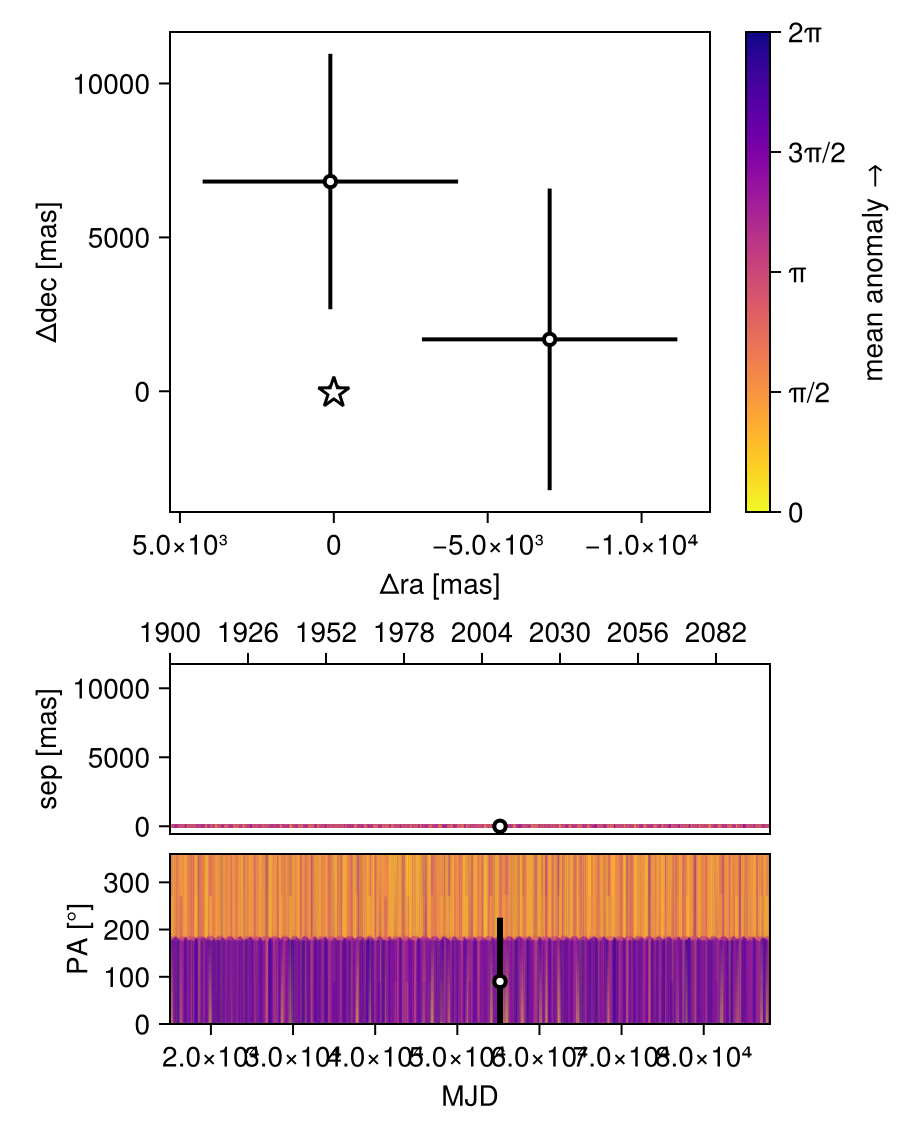

[ Info: pass true or false for each of these arguments to suppress this message.


In [16]:
# Use the octoplot function to generate plots. 
# You can use keyword arguments (see documentation) to control which output panels appear. 
# By default, they will be chosen automatically based on the kinds of data likelihoods you supply to the model.
# The output is automatically saved to a PNG file in your current folder, with a name based on the name of the System you created. 
# You can also customize this using the fname argument (see docs for more details). 
# You can change the image format (eg to PDF) by changing the file name extension.
octo.octoplot(model,chain)

In [8]:
"""
Observed 2D Velocities and Accelerations 
----------------------------------------
Observational data for 7 high-velocity stars in Omega Centauri
Calculations of plane-of-sky accelerations and propagation of uncertainties
"""

# ========================================================
# 1. Input: Measured Proper Motion Velocities (v2D)
# ========================================================

# 2D velocities in the plane of the sky [km/s]
# Sources A–G
v2D = np.array([113.0, 66.6, 94.9, 77.9, 69.6, 67.4, 66.2]) * u.km / u.s

# Corresponding 1σ uncertainties [km/s]
v2D_err = np.array([1.1, 4.1, 1.7, 2.0, 0.8, 0.4, 1.9]) * u.km / u.s

# ========================================================
# 2. Input: Angular Accelerations from Astrometry (RA/Dec)
# ========================================================

# Accelerations in Right Ascension [mas/yr²]
a_ra = np.array([-0.0069, 0.0702, 0.0028, 0.0357, 0.0072, 0.0052, -0.0197]) * u.mas / u.yr**2
a_ra_err = np.array([0.0083, 0.0239, 0.0333, 0.0177, 0.0042, 0.0038, 0.0267]) * u.mas / u.yr**2

# Accelerations in Declination [mas/yr²]
a_dec = np.array([0.0085, 0.0228, -0.0060, -0.0194, -0.0009, -0.0015, 0.0173]) * u.mas / u.yr**2
a_dec_err = np.array([0.0098, 0.0157, 0.0123, 0.0162, 0.0075, 0.0038, 0.0170]) * u.mas / u.yr**2

# ========================================================
# 3. Total Angular Acceleration and Uncertainty (Plane-of-Sky)
# ========================================================

# Total angular acceleration [mas/yr²]
a_total_masyr2 = np.sqrt(a_ra**2 + a_dec**2)

# Propagate uncertainty using partial derivatives
a_total_masyr2_err = np.sqrt(
    (a_ra * a_ra_err / a_total_masyr2)**2 +
    (a_dec * a_dec_err / a_total_masyr2)**2
)

# ========================================================
# 4. Conversion to Physical Acceleration [km/s²]
# ========================================================

# Convert angular acceleration to physical acceleration using cluster distance
a_total = utils.masyr2_to_kms2(a_masyr2=a_total_masyr2, distance_km=utils.distance_km)
a_total_err = utils.masyr2_to_kms2(a_masyr2=a_total_masyr2_err, distance_km=utils.distance_km)

# ========================================================
# 5. Create Summary Data Table
# ========================================================

# Build astropy table of all values
star_data = Table({
    "v2D": v2D,
    "v2D_err": v2D_err,
    "a_ra": a_ra,
    "a_ra_err": a_ra_err,
    "a_dec": a_dec,
    "a_dec_err": a_dec_err,
    "a_total": a_total,
    "a_total_err": a_total_err,
})

# Final table 
star_data

v2D,v2D_err,a_ra,a_ra_err,a_dec,a_dec_err,a_total,a_total_err
km / s,km / s,mas / yr2,mas / yr2,mas / yr2,mas / yr2,km / s2,km / s2
float64,float64,float64,float64,float64,float64,float64,float64
113.0,1.1,-0.0069,0.0083,0.0085,0.0098,8.930061383293236e-09,7.531455373299496e-09
66.6,4.1,0.0702,0.0239,0.0228,0.0157,6.02047938832453e-08,1.8958529783912896e-08
94.9,1.7,0.0028,0.0333,-0.006,0.0123,5.400731419743836e-09,1.4649029465648002e-08
77.9,2.0,0.0357,0.0177,-0.0194,0.0162,3.314142014778814e-08,1.4167818247443028e-08
69.6,0.8,0.0072,0.0042,-0.0009,0.0075,5.918566003817241e-09,3.483038561817065e-09
67.4,0.4,0.0052,0.0038,-0.0015,0.0038,4.4144539757184885e-09,3.0995661122692196e-09
66.2,1.9,-0.0197,0.0267,0.0173,0.017,2.1385320005943142e-08,1.8748565257835362e-08
